# 3.5.1.2 Agent의 히스토리를 관리하는 방법

### (방법2) 노드를 추가해서 지우는 방법
- 다음 파일에....

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

small_llm = ChatOpenAI(model="gpt-4o")

이 덧셈 도구도 추가할 예정

In [3]:
from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

간단한 웹 검색 도구를 활용하자.  

[Tavily](https://tavily.com/)는 매월 1000건의 무료 호출을 제공하지만 [DuckDuckGo](https://duckduckgo.com/)는 완전 무료

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search_tool = DuckDuckGoSearchRun()

[GmailToolkit](https://python.langchain.com/docs/integrations/tools/gmail)은 구글 메일 도구를 제공   
먼저 `credentials` 설정 후에 사용할 수 있음

매뉴얼을 보면 사용하는 방법이 두가지 이다.  
- 방법1: 로컬에 credential.json파일을 읽는 방법
```python
from langchain_google_community import GmailToolkit

toolkit = GmailToolkit()
```

- 방법2: 커스텀 인증 방법
```python
from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
toolkit = GmailToolkit(api_resource=api_resource)
```

- 두번째 방법 추천

우선 다음 링크를 참고해서 credential을 생성해서 json파일 다운로드
- https://developers.google.com/workspace/gmail/api/quickstart/python

이후 안되면 권한 승인 필요
- https://console.cloud.google.com/auth/audience?inv=1&invt=Ab1OBg&project=my-first-project-409013

In [5]:
from langchain_google_community import GmailToolkit

from langchain_google_community.gmail.utils import (
    build_resource_service,
    get_gmail_credentials,
)

# Can review scopes here https://developers.google.com/gmail/api/auth/scopes
# For instance, readonly scope is 'https://www.googleapis.com/auth/gmail.readonly'
credentials = get_gmail_credentials(
    token_file="./google/gmail_token.json",
    scopes=["https://mail.google.com/"],
    client_secrets_file="./google/gmail_credentials.json",
)
api_resource = build_resource_service(credentials=credentials)
gmail_toolkit = GmailToolkit(api_resource=api_resource)
gmail_tool_list = gmail_toolkit.get_tools()

In [6]:
gmail_tool_list

[GmailCreateDraft(api_resource=<googleapiclient.discovery.Resource object at 0x1334d1cd0>),
 GmailSendMessage(api_resource=<googleapiclient.discovery.Resource object at 0x1334d1cd0>),
 GmailSearch(api_resource=<googleapiclient.discovery.Resource object at 0x1334d1cd0>),
 GmailGetMessage(api_resource=<googleapiclient.discovery.Resource object at 0x1334d1cd0>),
 GmailGetThread(api_resource=<googleapiclient.discovery.Resource object at 0x1334d1cd0>)]

- 이메일 작성, 이메일 보내기, 이메일 검색, 받기 등이 된다.

[load_tools](https://api.python.langchain.com/en/latest/agents/langchain.agents.load_tools.load_tools.html) 함수를 통해 내장 도구를 불러올 수 있음

In [7]:
from langchain.agents import load_tools

loaded_tool_list = load_tools(
    ["arxiv"],
)

마지막으로 create_retriever_tool을 사용하면 리트리버를 쉽게 도구로 구성할 수 있다.

In [8]:
import os

from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.tools.retriever import create_retriever_tool

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-large",
)
vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="real_estate_tax_retriever",
    description="Contains information about real estate tax up to December 2024",
)

`ToolNode`에 도구 리스트를 전달한다.

In [9]:
from langgraph.prebuilt import ToolNode

tool_list = (
    [add, multiply, search_tool, retriever_tool] + gmail_tool_list + loaded_tool_list
)
llm_with_tools = small_llm.bind_tools(tool_list)
tool_node = ToolNode(tool_list)

- `state`를 선언하고 agent를 생성합니다

In [10]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메시지를 가져와
    LLM과 도구를 사용하여 응답 메시지를 생성합니다.

    Args:
        state (MessagesState): 메시지 상태를 포함하는 state.

    Returns:
        MessagesState: 응답 메시지를 포함하는 새로운 state.
    """
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

### 중요: 삭제를 위한 delete_messages노드 추가

In [12]:
from langchain_core.messages import RemoveMessage


def delete_messages(state: MessagesState):
    messages = state["messages"]
    delete_messages = [RemoveMessage(id=message.id) for message in messages[:-3]]
    return {"messages": delete_messages}

### 중요: should_continue 추가하기  
delete_messages를 추가하려면 기존 prebuilt인 tools_condition을 사용하지 못한다.   
그래서 should_continue 노드를 만들어 줘야 한다.

In [13]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_ai_message = messages[-1]
    if last_ai_message.tool_calls:
        return "tools"

    return "delete_messages"

`node`를 추가하고 `edge`로 연결합니다

**delete_messages도 추가해준다.**

In [14]:
graph_builder.add_node("agent", agent)
graph_builder.add_node("tools", tool_node)
graph_builder.add_node(
    delete_messages
)  # 중요: 노드 이름과 함수 이름이 같으면 이같이 해도 괜찮다.

Conditional_edge 수정

In [15]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition


graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges(
    "agent", should_continue, ["tools", "delete_messages"]
)
graph_builder.add_edge("tools", "agent")
graph_builder.add_edge("delete_messages", END)

### (중요) 이제, MemorySaver를 추가

In [16]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)

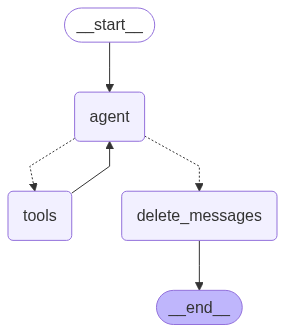

In [17]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

checkpoint가 생겼기 때문에 스레드 관리를 해줘야 한다.  
config를 사용해서 관리

In [18]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "paper_summary"}}

In [19]:
query = "sguys99@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요. 한글로 작성하세요."

for chunk in graph.stream(
    {"messages": [HumanMessage(query)]}, config=config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

sguys99@gmail.com으로 Attention Is All You Need 논문을 요약해서 이메일 초안을 작성해주세요. 한글로 작성하세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_Zn3FTl55FVqnOFFTVVNwXIjz)
 Call ID: call_Zn3FTl55FVqnOFFTVVNwXIjz
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Lla

In [20]:
update_query = "논문의 출처 url을 첨부해 주세요."

for chunk in graph.stream(
    {"messages": [HumanMessage(update_query)]}, config=config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

논문의 출처 url을 첨부해 주세요.
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_iM4uZoFj7gL34RwFakxTfKtP)
 Call ID: call_iM4uZoFj7gL34RwFakxTfKtP
  Args:
    query: Attention Is All You Need
================================= Tool Message =================================
Name: arxiv

Published: 2024-07-22
Title: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models
Authors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini
Summary: The inference demand for LLMs has skyrocketed in recent months, and serving
models with low latencies remains challenging due to the quadratic input length
complexity of the attention layers. In this work, we investigate the effect of
dropping MLP and attention layers at inference time on the performance of
Llama-v2 models. We find that dropping dreeper attention layers 

In [21]:
update_query = "초안이 좋습니다. 이메일을 전송해 주세요."

for chunk in graph.stream(
    {"messages": [HumanMessage(update_query)]}, config=config, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

초안이 좋습니다. 이메일을 전송해 주세요.
================================== Ai Message ==================================
Tool Calls:
  send_gmail_message (call_MevD9ZaRa00Si8bvXWEHOwjN)
 Call ID: call_MevD9ZaRa00Si8bvXWEHOwjN
  Args:
    message: 안녕하세요,

다음은 'Attention Is All You Need' 논문의 요약입니다.

'Attention Is All You Need' 논문은 자연어 처리에서 Transformer 모델의 핵심 개념인 어텐션 메커니즘에 대해 설명합니다. 이 논문은 전통적인 순환 신경망(RNN)과 달리 어텐션 메커니즘만을 사용하여 번역 작업을 수행하는 모델을 제안하며, 이는 계산 효율성과 성능 면에서 뛰어납니다.

Transformer 모델은 인코더와 디코더 구조로 이루어져 있으며, 각 층은 셀프 어텐션과 피드 포워드 네트워크로 구성됩니다. 셀프 어텐션 메커니즘은 입력 시퀀스의 각 요소가 서로 얼마나 관련이 있는지를 계산하여 문맥을 이해하는 데 도움을 줍니다.

이 논문은 어텐션 메커니즘이 다른 복잡한 구조 없이도 높은 성능을 낼 수 있음을 보여주며, 이후 다양한 자연어 처리 작업에서 널리 사용되는 계기가 됩니다.

논문의 출처 URL: [Attention Is All You Need](https://arxiv.org/abs/1706.03762)

감사합니다.
    to: sguys99@gmail.com
    subject: Attention Is All You Need 논문 요약
================================= Tool Message ===============================